## Objective:
A Retail Superstore chain wants to gain insights on the performance of each its stores and make strategic decisions on its operating model.

As a Data Scientist you are required to understand the data provided and help the client predict the sales at the register in current hour based on the sales attribute associated with each store.

The given data consists of 4 broad attribute types:
   * Register: Attributes related to the register at which the sales transaction has taken place
   * Cashier: Attributes related to cashier working at the register
   * Store: Attributes related to a particular store
   * Region: Attributes related to a group of stores in the region



## Problem Statement:
Predict the sales at the register in current hour and prioritize the individual attributes that affect the sales.


#### Upload your datasets to colab using upload to storage session taskbar

## Import Required Libraries

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
#
import xgboost as xgb
import catboost as cb
import shap
#
import os
import sys
#
from datetime import datetime, timedelta
from time import time
from uuid import uuid4
from scipy.ndimage import convolve1d
#
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_validate
# 
from featurewiz import featurewiz
#
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

np.random.seed(1234)
%matplotlib inline

## Label Encoding and Null Value Imputaion Functions

In [2]:
def impute_nulls(df, imputation_cols, imputation_mapping={}):
    '''Imputes NULL values for a set of continuous variable columns.
       NULLs will be sampled from a normal distribution defined by the
       mean & std.dev of the other data in the column.

       You can also provide a mapping of such means & std.devs in the
       'imputation_mappings' variable, e.x.:
           {'input_var1': {'mean': 1.045, 'std': 0.034}, ...}
       The mappings will be returned along with the transformed DataFrame.
       This allows re-use of the same NULL imputations on other datasets.'''

    # Impute NULLs in each desired input column separately
    for col in imputation_cols:

        # Lookup mean & std.dev from imputation mappings, if they exist.
        # Otherwise compute them from input data
        try:
            mean_val = imputation_mapping[col]['mean']
            std_val = imputation_mapping[col]['std']
        except KeyError:
            mean_val = df[col].mean(skipna=True)
            std_val = df[col].std(skipna=True)
            imputation_mapping[col] = {'mean': mean_val, 'std': std_val}

        # Transform NULL values by sampling a normal distribution with mean & std.dev computed above
        mask = df[col].isnull()
        n_nulls = sum(mask)
        if ( n_nulls > 0 ):
            print('WARN: Replaced {0:>4d} NULLs   ({1:s})'.format(n_nulls, col))
            imputed_vals = np.random.normal(mean_val, std_val, n_nulls)
            df.loc[mask,col] = imputed_vals

    return df, imputation_mapping


def encode_categoricals(df, categorical_cols):
    '''Performs one-hot encoding of categorical variable columns.
       Each distinct level value will be mapped to its own new column.

       For example, suppose input_col = 'variable1' and it has 3 possible
       values: 'A', 'B', 'C'. Then we'll produce 3 new columns:
           'is_variable1=A', 'is_variable1=B', 'is_variable1=C'

       NOTE: It's possible for encodings to mis-align between the train/test
           and validation sets. Hopefully the training set contains a superset
           of level values.'''

    # Encode categoricals in each input column separately
    for col in categorical_cols:

        # For each distinct level value in the column, create a new one-hot column.
        # Use a mask to set values to 0/1 appropriately
        level_vals = df[col].unique()
        for val in level_vals:
            encoded_col = 'is_{0:s}={1:s}'.format(col, str(val))
            mask = df[col] == val
            df.loc[mask,encoded_col] = 1
            df.loc[~mask,encoded_col] = 0

    return df


## Weight Sampling to reduce bias

In [3]:
def get_smoothing_kernel(kernel_size=5, sigma=1.0):
    '''Builds a Gaussian smoothing kernel of a desired size (# of elements) and
       spread. The Gaussian will be positioned at the center of the kernel.'''

    # Calculate a Gaussian with mean x0 = 0 and std = sigma
    # NOTE: Renormalize so sum(y) = 1.0
    x = np.linspace(-(kernel_size-1) / 2., (kernel_size - 1) / 2., kernel_size)   # x-lims for Gaussian
    kernel = np.exp(-0.5 * np.square(x) / np.square(sigma))
    kernel = kernel / np.sum(kernel)

    return kernel


def get_sample_weights(target_vals, target_bins,
                       smoothing_kernel_props={'size': 51, 'sigma': 5},
                       weighting_method='inverse_square',
                       max_weight=100,
                       make_plots=False):
    '''Gets reweighting factors for each sample in a regression problem, following the
       LDS method detailed here:
           https://towardsdatascience.com/strategies-and-tactics-for-regression-on-imbalanced-data-61eeb0921fca

       Essentially, we do these steps:
       1.) Get a histogram of target values
       2.) Use a Gaussian filter to smooth the histogram
       3.) Use inverse or inverse-sqrt of counts to weight each bin
       4.) Map each sample to its new weight

       The output 'sample_weights' vector will be the same shape as 'target_vals'.
    '''

    # Get the histogram / distribution of target values -- these will be our 'classes'
    # NOTE: Convert to float for convolution below
    [counts, bins] = np.histogram(target_vals, bins=target_bins)
    counts = [float(c) for c in counts]

    # Apply a Gaussian smoothing filter to the counts distribution
    # NOTE: Renormalize so the convolved distribution maintains the same # of total counts
    kernel = get_smoothing_kernel(kernel_size=smoothing_kernel_props['size'], sigma=smoothing_kernel_props['sigma'])
    smooth_counts = convolve1d(counts, weights=kernel, mode='mirror')
    smooth_counts = smooth_counts * ( sum(counts) / sum(smooth_counts) )

    # Make sure there are no 0-count bins. Replace them with the lowest non-zero count
    mask = ( smooth_counts == 0 )
    smooth_counts[mask] = np.min( smooth_counts[np.nonzero(smooth_counts)] )

    # Get weights for each 'class' from the smoothed counts
    # NOTE: Supports either 1/N or 1/N^2 reweighting
    class_weights = np.ones(smooth_counts.shape)   # Default: No reweighting
    if ( weighting_method == 'inverse_square' ):
        class_weights = 1 / np.sqrt(smooth_counts)
    if ( weighting_method == 'inverse' ):
        class_weights = 1 / smooth_counts

    # Now map each sample to the corresponding class weight
    # NOTE: np.digitize returns the bin index used in histogramming. With k bins, we get k-1 class weights
    idxs = np.digitize(target_vals, target_bins) - 1
    sample_weights = class_weights[idxs]

    # Rescale weights so the sum(sample_weights) = n_samples. This is what we'd get without reweighting
    n_samples = len(target_vals)
    scaling_factor = n_samples / sum(sample_weights)
    sample_weights = sample_weights * scaling_factor

    # Truncate very large weights to reduce noise (especially helpful for 'inverse' weighting mode)
    sample_weights = np.clip(sample_weights, 0, max_weight)

    # (OPTIONAL) Make plots of both the weights & the target distributions (smoothed & unsmoothed)
    if ( make_plots ):

        # Plot 1: Target distribution (smoothed vs. unsmoothed)
        fig = plt.figure(figsize=[8,4])
        ax = fig.gca()
        plt.plot(target_bins[1:], counts)
        plt.plot(target_bins[1:], smooth_counts, color='orange')
        plt.title('Class Distributions', size=20)
        plt.xlabel('Target Value', size=16)
        plt.ylabel('Counts', size=16)
        ax.tick_params(axis='both', labelsize=14)
        plt.xlim([target_bins[0], target_bins[-1]])
        plt.ylim([0,None])
        plt.grid('minor')
        plt.legend(['Original', 'Smoothed'], fontsize=14)

        # Plot 2: Class weights
        fig = plt.figure(figsize=[8,4])
        ax = fig.gca()
        plt.plot(target_bins[1:], np.clip(class_weights * scaling_factor, 0, max_weight))
        plt.hlines([1], target_bins[0], target_bins[-1], colors='orange')
        plt.title('Class Weights', size=20)
        plt.xlabel('Target Value', size=16)
        plt.ylabel('Weight', size=16)
        ax.tick_params(axis='both', labelsize=14)
        plt.xlim([target_bins[0], target_bins[-1]])
        plt.ylim([0,None])
        plt.grid('minor')
        plt.legend(['Reweighted', 'Unweighted'], fontsize=14)

    return sample_weights


## Define Hyperparameter Tuning parameters

In [4]:
HYPERPARAMETER_DTYPES = {
    'n_estimators': int,
    'max_depth': int,
    'learning_rate': float
}

## Define Heperparameter tuning function

In [5]:
def random_search_xgb(hyperparameter_space, X_train, y_train,
                      wt_train=None,
                      metric_to_optimize='r2',
                      n_runs=100,
                      n_folds=5,
                      n_jobs=4,
                      print_status=True):
    '''Performs random search hyperparameter tuning for an XGBoost model. We'll evaluate model
       performance at many random points in the hyperparameter space, choosing the best result
       that was found. Supports sample reweighting via 'wt_train'.

       Parameters are optimized using cross-validation of a specified model evaluation metric:
           -- 'r2'
           -- 'rmse'
           -- 'mae'
           -- 'mape'
           -- 'racc'
       This last one is the 'regression accuracy' at 10% maximum error, i.e. the number
       of predictions that are within 10% of true.

       Each key in the hyperparameter_space dictionary should be a named hyperparameter,
       while values should be arrays containing the min/max values to test.

       Returns the trained optimal model, along with performance metrics and the optimal
       hyperparameters used.

       NOTE: Currently only support 'n_estimators', 'max_depth', and 'learning_rate'.'''

    t0 = time()

    # Initialize the return values
    optimal_model = None
    optimal_hyperparameters = {}
    optimal_eval_metrics = None

    # Print status message
    if ( print_status ):
        print('XGBoost Hyperparameter Search')
        print('-'*40)
        print('Method:       {0:s}'.format('random-search'))
        print('Dataset:      {0:d} pts x {1:d} dimensions'.format(X_train.shape[0], X_train.shape[1]))
        print('Optimizer:    {0:s}'.format(metric_to_optimize.upper()))
        print('# of Runs:    {0:d}'.format(n_runs))
        print()
        print('Hyperparameter Space:')
        for param in hyperparameter_space.keys():
            print('-- {0:<16s} [{1:s}]'.format(param+':', ', '.join([str(val) for val in hyperparameter_space[param]]) ))
        print('\n')

    # Try a bunch of random sets of hyperparameters, returning results for the best one
    optimal_metric_val = None
    n_evals = 0
    for run_num in range(n_runs):

        # Pick some random hyperparameters to start with
        current_hyperparameters = get_random_hyperparameters(hyperparameter_space)
        current_metric_val = None

        # (OPTIONAL) Print progress
        if ( print_status ):
            format_str = 'Progress: Run {0:>3s} / {1:d}   -->   Hyperparameters: {2:s}' + ' '*80
            print(format_str.format('#{0:d}'.format(run_num+1), n_runs, str(current_hyperparameters)), end='\r', flush=True)

        # Evaluate an XGBoost Regressor with the current hyperparameters
        current_model = initialize_model_xgb(current_hyperparameters)
        [current_eval_results, _] = evaluate_regression_model(current_model, X_train=X_train, y_train=y_train, wt_train=wt_train,
                                                              n_folds=n_folds, n_jobs=n_jobs)
        n_evals += 1

        # Compare model performance w/ best found so far
        current_metric_val = current_eval_results[metric_to_optimize]['mean']
        if ( ( optimal_metric_val is None ) or ( current_metric_val > optimal_metric_val ) ):
            optimal_metric_val = current_metric_val
            optimal_hyperparameters = current_hyperparameters
            optimal_eval_results = current_eval_results


    # Train the final optimized model
    optimal_model = train_model_xgb(optimal_hyperparameters, X_train, y_train, wt_train=wt_train)

    # (OPTIONAL) Print summary
    if ( print_status ):
        print('\n\n')
        print('Search Complete')
        print('-'*40)
        print('Optimal Params:      {0:s}'.format(str(optimal_hyperparameters)))
        print('Model Performance:   {0:s} = {1:3.4f}'.format(metric_to_optimize, optimal_metric_val))
        print('Params Evaluated:    {0:d}'.format(n_evals))
        print('Execution Time:      {0:3.2f}s'.format(time()-t0))
        print()

    return optimal_model, optimal_hyperparameters, optimal_eval_results


def get_random_hyperparameters(hyperparameter_space):
    '''Randomly selects a point in hyperparameter space. Outputs will fall within the
       provided ranges'''

    # For each hyperparameter, pick a random value somewhere within the provided range
    hyperparameters = {}
    for param in hyperparameter_space.keys():
        min_value = min(hyperparameter_space[param])
        max_value = max(hyperparameter_space[param])
        hyperparameters[param] = min_value + (max_value - min_value) * np.random.random()

        # Convert to desired datatype
        if ( HYPERPARAMETER_DTYPES[param] == int ):
            hyperparameters[param] = int(np.round(hyperparameters[param]))

    return hyperparameters


def initialize_model_xgb(hyperparameters):
    '''Initializes an XGBoost Regressor w/ desired hyperparameters'''

    xgb_model = xgb.XGBRegressor(n_estimators=int(hyperparameters['n_estimators']),
                                 max_depth=int(hyperparameters['max_depth']),
                                 learning_rate=hyperparameters['learning_rate'])

    return xgb_model


def train_model_xgb(hyperparameters, X_train, y_train, wt_train=None):
    '''Trains an XGBoost Regressor with a desired set of hyperparameters. Supports
       sample reweighting via 'wt_train'.'''

    # Initialize the model w/ desired hyperparameters
    xgb_model = initialize_model_xgb(hyperparameters)

    # Fit to training data
    xgb_model.fit(X_train, y_train, sample_weight=wt_train)

    return xgb_model


## Model Evaluation Functions

In [6]:
def evaluate_regression_model(regression_model,
                              X_train=None,
                              y_train=None,
                              wt_train=None,
                              X_test=None,
                              y_test=None,
                              wt_test=None,
                              y_lims=[None,None],
                              n_folds=5,
                              n_jobs=4):
    '''Evaluates a regression model on a set of common performance metrics. Cross-validation
       is used to evaluate the training set (X_train, y_train), resulting in multiple values
       per metric. For the test set (X_test, y_test), metrics are computed on the model's
       predictions, resulting in a single value per metric. Supports any model architecture
       with *.fit() and *.predict() methods.

       Supports sample reweighting via 'wt_train'.

       NOTE: User has the option to coerce predictions within the range given by y_lims.'''

    # Initialize return values
    eval_results__train = {}
    eval_results__test = {}

    # If sample weights are provided, package them as a kwarg for cross_validate()
    fit_params = None
    if ( wt_train is not None ):
        fit_params = {'sample_weight': wt_train}

    # If a training set is provided, run cross-validation on it
    if ( ( X_train is not None ) and ( y_train is not None ) ):

        # Cross-validate model performance
        eval_metrics = {
            'r2': make_scorer(r2_score),
            'rmse': make_scorer(rmse),
            'mae': make_scorer(mae),
            'mape': make_scorer(mape),
            'racc': make_scorer(regression_accuracy)
        }
        eval_results = cross_validate(regression_model, X_train, y_train, fit_params=fit_params,
                                      cv=n_folds, scoring=eval_metrics, n_jobs=n_jobs)

        # Let's compute means & standard dev's for all metrics, and change the output names
        # NOTE: Cross-validation above gives the metric names a 'test_' prefix
        output_name_mappings = {
            'fit_time': 'fit_time',
            'score_time': 'score_time',
            'test_r2': 'r2',
            'test_rmse': 'rmse',#
            'test_mae': 'mae',
            'test_mape': 'mape',
            'test_racc': 'racc'
        }
        for metric in eval_results.keys():
            metric_ = output_name_mappings[metric]
            eval_results__train[metric_] = {
                'mean': np.mean(eval_results[metric]),
                'std': np.std(eval_results[metric]),
                'data': eval_results[metric]
            }

    # If a test set is provided, run evaluation on the predictions
    if ( ( X_test is not None ) and ( y_test is not None ) ):

        # Get measured & predicted results for the test dataset
        y_meas = y_test
        y_pred = regression_model.predict(X_test)

        # (OPTIONAL) Coerce predictions into allowed range (e.x. non-negative)
        if ( y_lims[0] is not None ):
            mask = y_pred < y_lims[0]
            y_pred[mask] = y_lims[0]
        if ( y_lims[1] is not None ):
            mask = y_pred > y_lims[1]
            y_pred[mask] = y_lims[1]

        # Compute the desired performance metrics
        eval_results__test = {
            'data': {'y_meas': y_meas, 'y_pred': y_pred},
            'r2': r2_score(y_meas, y_pred),
            'rmse': rmse(y_meas, y_pred),
            'mae': mae(y_meas, y_pred),
            'mape': mape(y_meas, y_pred),
            'racc': regression_accuracy(y_meas, y_pred)
        }
    return eval_results__train, eval_results__test


def regression_accuracy(y_meas, y_pred, max_error=20, error_type='relative'):
    '''Compares predicted & measured values, returning the percentage of predictions
       that are within a set error limit. This error limit can be an absolute value
       or a relative percentage'''

    # OPTION 1: Relative percentage
    if ( error_type == 'relative' ):
        mask = 100.0 * abs((y_pred - y_meas) / y_meas) < max_error

    # OPTION 2: Absolute value
    if ( error_type == 'absolute' ):
        mask = abs(y_pred - y_meas) < max_error

    accuracy = sum(mask) / len(mask)

    return accuracy


def rmse(y_meas, y_pred):
    '''Computes RMSE for predicted vs. measured data points'''

    n_samples = len(y_meas)
    rmse = np.linalg.norm(y_pred - y_meas) / np.sqrt(n_samples)

    return rmse


def mae(y_meas, y_pred):
    '''Computes MAE for predicted vs. measured data points'''

    n_samples = len(y_meas)
    mae = np.sum(np.abs(y_pred - y_meas)) / n_samples

    return mae


def mape(y_meas, y_pred):
    '''Computes MAPE for predicted vs. measured data points'''

    n_samples = len(y_meas)
    mape = np.sum(np.abs((y_pred - y_meas)/y_meas)) / n_samples

    return mape


## Function to  visualize data

In [7]:
# Define a few standard color palettes
color_palettes = {

    'tableau': [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ],

    'blues': ['darkblue', 'blue', 'slateblue', 'rebeccapurple', 'indigo'],

    'oranges': ['darkorange', 'orange', 'sandybrown', 'peru', 'saddlebrown']

}



In [8]:
def plot_distribution(data,
                      data_labels=None,
                      bins=None,
                      title='Distribution',
                      xlabel='Variable',
                      hist_units='counts',
                      output_filepath=None):
    '''Plots the probability distribution of one or more variables. User can choose
       output in counts/bin or probability/bin.'''

    # Define default bin structure if not provided
    if ( bins is None ):
        n_bins = 50
        min_val = None
        max_val = None
        for dataset in data:
            this_min = np.nanmin(dataset)
            this_max = np.nanquantile(dataset, 0.99) #np.nanmax(dataset)
            if ( min_val is None ):
                min_val = this_min
            elif ( this_min < min_val ):
                min_val = this_min
            if ( max_val is None ):
                max_val = this_min
            elif ( this_max > max_val ):
                max_val = this_max
        bins = np.linspace(min_val, max_val, n_bins)

    # Set up plot
    fig = plt.figure(figsize=[10,8], facecolor='w')
    ax = plt.gca()

    # Plot a histogram for each input data series
    # NOTE: Normalize to probability per bin if desired
    for dataset in data:
        [counts,bins] = np.histogram(dataset, bins=bins)
        counts_ = np.append([0], counts)
        if ( hist_units == 'probability' ):
            counts_ = counts_ / sum(counts_)
        plt.step(bins,counts_)

    # Set up plot properties
    plt.title(title, size=24)
    plt.xlabel(xlabel, size=20)
    if ( hist_units == 'probability' ):
        plt.ylabel('Probability Density\n(1/Bin)', size=20)
    if ( hist_units == 'counts' ):
        plt.ylabel('Counts\n(#/Bin)', size=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim([bins[0],bins[-1]])
    plt.ylim([0,None])
    plt.grid('minor')

    # Set up legend
    if ( data_labels is not None ):
        ax.legend(data_labels, fontsize=16, shadow=True)
        #bbox_to_anchor = [1.05,0.5]
        #ax.legend(data_labels, loc='center left', fontsize=16, shadow=True, bbox_to_anchor=bbox_to_anchor)

    # (OPTIONAL) Save figure if desired
    if ( output_filepath is not None ):
        plt.savefig(output_filepath, bbox_inches='tight')
    plt.show()
#

def plot_heatmap(x, y,
                 x_bins=None,
                 y_bins=None,
                 aspect='equal',
                 scale='log',
                 title='Heatmap',
                 xlabel='Variable 1',
                 ylabel='Variable 2',
                 cmap='Reds',
                 plot_diagonal=False,
                 output_filepath=None):
    '''Renders a heatmap of y vs. x. Generally produces a clearer visualization
       than a simple scatterplot'''

    # Define default bin structures if they weren't provided
    if ( x_bins is None ):
        x_bins = np.linspace(min(x), max(x), 100)
    if ( y_bins is None ):
        y_bins = np.linspace(min(y), max(y), 100)

    # Bin the data into a 2D histogram
    [counts, x_bins, y_bins] = np.histogram2d(x, y, bins=[x_bins, y_bins])
    counts = np.transpose(counts)

    # Set up colormap scale
    # NOTE: Enforce 'linear' scale if counts are too low
    if ( np.max(counts) < 10 ):
        scale = 'linear'
    color_norm = None
    if ( scale == 'log' ):
        color_norm = colors.LogNorm(vmin=1, vmax=counts.max())
        # If using log-scale, set 0-count bins to 1. Otherwise we'll have missing pixels in the heatmap
        mask = counts == 0
        counts[mask] = 1

    # Render a heatmap from the counts, using bin limits to define the extent of the figure
    fig = plt.figure(figsize=[12.5,8], facecolor='w')
    ax = plt.gca()
    cb = plt.imshow(counts, cmap=cmap, norm=color_norm,
                    origin='lower', aspect=aspect, interpolation='bilinear',
                    extent=[x_bins[0],x_bins[-1],y_bins[0],y_bins[-1]])

    # Set up plot properties
    plt.title(title, size=24)
    plt.xlabel(xlabel, size=20)
    plt.ylabel(ylabel, size=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid('minor')
    fig.colorbar(cb, ax=ax)
    bbox_props = dict(facecolor='w', edgecolor='k')

    # (OPTIONAL) Plot a dashed line along the diagonal
    if ( plot_diagonal ):
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.plot(xlims, ylims, linestyle='--', linewidth=1, color=[0.25,0.25,0.25])

    # (OPTIONAL) Save figure if desired
    if ( output_filepath is not None ):
        plt.savefig(output_filepath, bbox_inches='tight')
    plt.show()

#
def plot_regression_accuracy(y_meas, y_pred,
                             min_error=0.0,
                             max_error=100.0,
                             error_type='relative',
                             title='Model Accuracy',
                             xlabel='Maximum Error\n(%)',
                             ylabel='Accuracy\n(%)',
                             output_filepath=None):
    '''Plot classification accuracy of a regression model as a function of maximum
       allowed error. For example, if we require predictions to be within +/- 10% of
       the true measured answer, then we can convert continuous regression output to
       a simple Y/N answer. Was the prediction within 10%?

       Calculates accuracy for increasingly permissive errors. A highly-performant
       model will have most samples fall within a small regression error.'''

    # Calculate accuracy as a function of regression error
    n_bins = 100
    error_limits = np.linspace(min_error, max_error, n_bins)
    accuracies = np.zeros(n_bins)
    for n in range(n_bins):
        accuracies[n] = regression_accuracy(y_meas, y_pred, max_error=error_limits[n], error_type=error_type)

    # Set up plot
    fig = plt.figure(figsize=[8,8], facecolor='w')
    ax = plt.gca()
    plt.plot(error_limits, 100*accuracies)

    # Set up plot properties
    plt.title(title, size=24)
    plt.xlabel(xlabel, size=20)
    plt.ylabel(ylabel, size=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim([error_limits[0], error_limits[-1]])
    plt.ylim([0,100])
    plt.grid('minor')

    # (OPTIONAL) Save figure if desired
    if ( output_filepath is not None ):
        plt.savefig(output_filepath, bbox_inches='tight')
    plt.show()


## Define function to Load The data

In [9]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
output_path = 'C:/Users/abhij/OneDrive - Indiana University/Hackathons/Juniper Networks Global AI Challenge/Results'

## Define function to load dataset

In [10]:
def load_dataset(input_filepath, dataset_name=None, datetime_cols=None):
    '''Loads a *.txt file into a Pandas DataFrame'''
    
    t0 = time()
    df = pd.read_csv(input_filepath, sep=',', parse_dates=datetime_cols, infer_datetime_format=True)

    # Print status message
    print('Dataset Summary')
    print('----------------------------')
    print('Name:    {0:s}'.format(str(dataset_name)))
    print('Records: {0:d}'.format(df.shape[0]))
    print('Columns: {0:d}'.format(df.shape[1]))
    print('Size:    {0:3.2f}MB'.format(df.memory_usage(deep=True).sum() / 1000000))
    print('Time:    {0:3.2f}s'.format(time() - t0))
    print()
    
    return df

## Load the data

In [11]:
################################################################################
# Load input datasets
################################################################################

# Train dataset
input_filepath = 'training_dataset.csv'
train_df = load_dataset(input_filepath, dataset_name='train', datetime_cols=['observation_timestamp'])

# Test dataset
input_filepath = 'test_dataset.csv'
test_df = load_dataset(input_filepath, dataset_name='test', datetime_cols=['observation_timestamp'])


Dataset Summary
----------------------------
Name:    train
Records: 18512
Columns: 63
Size:    12.95MB
Time:    0.14s

Dataset Summary
----------------------------
Name:    test
Records: 5179
Columns: 61
Size:    3.54MB
Time:    0.05s



In [12]:
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
train_init = train_df.copy(deep=True)

## Defining Features and Targets

This is just for reference, competitors are free chose the features of their and experiment further.

In [81]:
################################################################################
# Define training target & feature columns
# NOTE: All columns will need to be numeric to work with sklearn or XGBoost! 
################################################################################

# Target: What we're trying to predict
target_col = 'register__sales_dollar_amt_this_hour'
target_units = '$/hr'
target_label = 'Register Sales Per Hour'
target_range = [0,5000]

# Index: What uniquely determines each record?
index_col = 'observation_id'

# Features: What we're using to predict the target
# NOTE: See the data dictionary for a complete list of available features

#feature_cols = train_columns_exp  # training columns including experimental features
feature_cols = train_columns

# feature_cols = [
#  'region__nighttime_open_registers',
#  'region__peak_returns_dollar_amt_per_hour',
#  'is_register__payment_types_accepted=Cash+Credit+Check',
#  'register__peak_sales_dollar_amt_per_hour',
#  'region__peak_sales_dollar_amt_per_hour',
#  'store__n_managers',
#  'cashier__title_level',
#  'region__nighttime_service_time_per_customer',
#  'store__miles_to_nearest_location',
#  'is_store__type_code=C',
#  'cashier__item_scan_rate_per_min',
#  'region__returns_dollar_amt_last_hour',
#  'store__gift_sales_quantity_last_hour',
#  'register__returns_dollar_amt_last_hour',
#  'store__sales_dollar_amt_last_hour',
#  'store__occupancy_backrooms',
#  'store__occupancy_indoors',
#  'store__returns_quantity_last_hour'
# ]

# feature_cols = [
#     'store__n_open_registers', 
#     'cashier__item_scan_rate_per_min',
#     'register__peak_sales_dollar_amt_per_hour',
#     'register__sales_quantity_rescanned_frac',
#     'store__occupancy_outdoors',
#     'region__n_open_registers',
#     'region__peak_sales_dollar_amt_per_hour',
#     #'region__peak_sales_dollar_amt_per_hour_v2',
#     'hour_of_day'
# ]

# Metadata: Not used in model training, but kept to tag the data
metadata_cols = ['observation_timestamp']

# Unused: All other columns (e.x. Unusable or unknown columns)
available_cols = train_df.columns.values
used_cols = [index_col, target_col] + feature_cols + metadata_cols
unused_cols = [col for col in available_cols if col not in used_cols]

# Print summary stats for the target variable
target_mean = train_df[target_col].mean()
target_std = train_df[target_col].std()
target_min = train_df[target_col].min()
target_max = train_df[target_col].max()
target_quantiles = train_df[target_col].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).values
target_iqr = target_quantiles[3] - target_quantiles[1]
print('Target Variable: {0:s}'.format(target_col))
print('----------------------------------------')
print('Units:  {0:s}'.format(target_units))
print('Mean:   {0:3.2f} +/- {1:3.2f}'.format(target_mean, target_std))
print('IQR:    {0:3.2f}'.format(target_iqr))
print()
print('|---------+---------+---------+---------+---------+---------+---------|')
print('|   Min   |   10%   |   25%   |   Med   |   75%   |   90%   |   Max   |')
print('|---------+---------+---------+---------+---------+---------+---------|')
print('|{0:^9.2f}|{1:^9.2f}|{2:^9.2f}|{3:^9.2f}|{4:^9.2f}|{5:^9.2f}|{6:^9.2f}|'.format(target_min, target_quantiles[0], target_quantiles[1], target_quantiles[2], target_quantiles[3], target_quantiles[4], target_max))
print('|---------+---------+---------+---------+---------+---------+---------|')


Target Variable: register__sales_dollar_amt_this_hour
----------------------------------------
Units:  $/hr
Mean:   1167.42 +/- 818.84
IQR:    1087.46

|---------+---------+---------+---------+---------+---------+---------|
|   Min   |   10%   |   25%   |   Med   |   75%   |   90%   |   Max   |
|---------+---------+---------+---------+---------+---------+---------|
|  15.71  | 309.48  | 369.19  | 1162.25 | 1456.65 | 2178.95 | 4978.65 |
|---------+---------+---------+---------+---------+---------+---------|


## Data Transformations

In [15]:
################################################################################
# Do some basic transformations
################################################################################

# This will only include one-hot encoding & NULL-imputation here.
# Let's transform each input dataset separately
categorical_cols = ['register__payment_types_accepted', 'store__type_code']
imputation_cols = [col for col in feature_cols if col not in categorical_cols]

# Dataset: train
print('Transforming \'train\' dataset...')
train_df = encode_categoricals(train_df, categorical_cols)
train_df, train_imputation_mapping = impute_nulls(train_df, ['region__peak_sales_dollar_amt_per_hour_v2', 'region__peak_returns_dollar_amt_per_hour_v2'], {'mean': 0.02, 'std': 1.00})
#[train_df, imputation_mapping] = impute_nulls(train_df, imputation_cols)
print()

# Dataset: test
print('Transforming \'test\' dataset...')
test_df = encode_categoricals(test_df, categorical_cols)
test_df, test_imputation_mapping = impute_nulls(test_df, ['region__peak_sales_dollar_amt_per_hour_v2', 'region__peak_returns_dollar_amt_per_hour_v2'], {'mean': -0.08, 'std': 0.98})
#[test_df, imputation_mapping] = impute_nulls(test_df, imputation_cols, imputation_mapping=imputation_mapping)
print()

# # Dataset: validation
# print('Transforming \'validation\' dataset...')
# valid_df = encode_categoricals(valid_df, categorical_cols)
# valid_df_imputed, valid_imputation_mapping = impute_nulls(valid_df, ['region__peak_sales_dollar_amt_per_hour_v2', 'region__peak_returns_dollar_amt_per_hour_v2'], {'mean': -0.08, 'std': 0.98})
# #[valid_df, imputation_mapping] = impute_nulls(valid_df, imputation_cols, imputation_mapping=imputation_mapping)
# print()

# Print status
print()
print('Transformations complete.')


Transforming 'train' dataset...
WARN: Replaced  198 NULLs   (region__peak_sales_dollar_amt_per_hour_v2)
WARN: Replaced 1900 NULLs   (region__peak_returns_dollar_amt_per_hour_v2)

Transforming 'test' dataset...
WARN: Replaced  100 NULLs   (region__peak_sales_dollar_amt_per_hour_v2)
WARN: Replaced  568 NULLs   (region__peak_returns_dollar_amt_per_hour_v2)


Transformations complete.


In [16]:
train_df.drop(['observation_id', 'register__payment_types_accepted', 'store__type_code'], axis=1, inplace=True)
test_df.drop(['observation_id', 'register__payment_types_accepted', 'store__type_code'], axis=1, inplace=True)

## Split the training data into Training and Validation(test) dataset

In [17]:
from sklearn.model_selection import train_test_split 
train_df,valid_df  = train_test_split(train_df,test_size=0.2,random_state=42)
print(f"train dataset shape :{train_df.shape}")
print(f"validation dataset shape : {valid_df.shape}")

train dataset shape :(14809, 68)
validation dataset shape : (3703, 68)


## Re-weight training samples

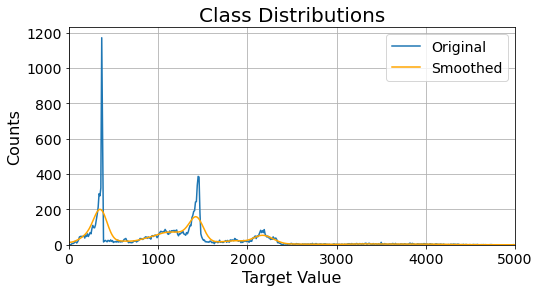

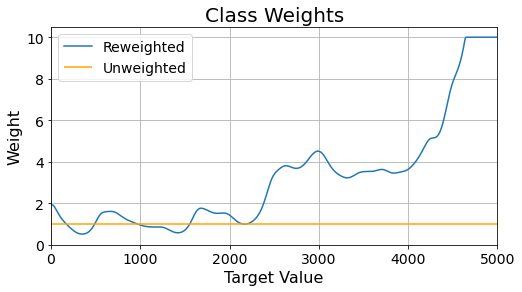

In [18]:
################################################################################
# Reweight training samples to reduce bias & improve performance where we have
# less data available. The resulting model should generalize somewhat better
################################################################################

target_vals = train_df[target_col].values
target_bins = np.linspace(target_range[0],target_range[1],501)
smoothing_kernel_props = {'size': 51, 'sigma': 7}
sample_weights = get_sample_weights(target_vals, target_bins, 
                                    smoothing_kernel_props=smoothing_kernel_props, 
                                    weighting_method='inverse_square', 
                                    max_weight=10,
                                    make_plots=True)
train_df['sample_weights'] = sample_weights


In [19]:
# Dropping the observation_timestamp column
train_df_notimestamp = train_df.drop(['observation_timestamp'], axis=1)

In [44]:
len(train_df_notimestamp.columns)

68

In [57]:
# Appending all columns/features for training excluding target column, timestamp, sample weights and experimental weights
train_columns = train_df_notimestamp.drop(['register__sales_dollar_amt_this_hour', 'sample_weights', 
                            'region__peak_sales_dollar_amt_per_hour_v2', 'region__peak_returns_dollar_amt_per_hour_v2'],axis=1).columns.tolist()

In [69]:
# Appending all columns/features (including experimental features) for training excluding target column, timestamp, sample weights
train_columns_exp = train_df_notimestamp.drop(['register__sales_dollar_amt_this_hour', 'sample_weights'],axis=1).columns.tolist()

## Feature Selection using Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Shape of your Data Set loaded: (14809, 68)
    Loaded train data. Shape = (14809, 68)
    Some column names had special characters which were removed...
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Regression problem ####
    loading a random sample of 10000 rows into pandas for EDA
#######################################################################################
######################## C L A S S I F 

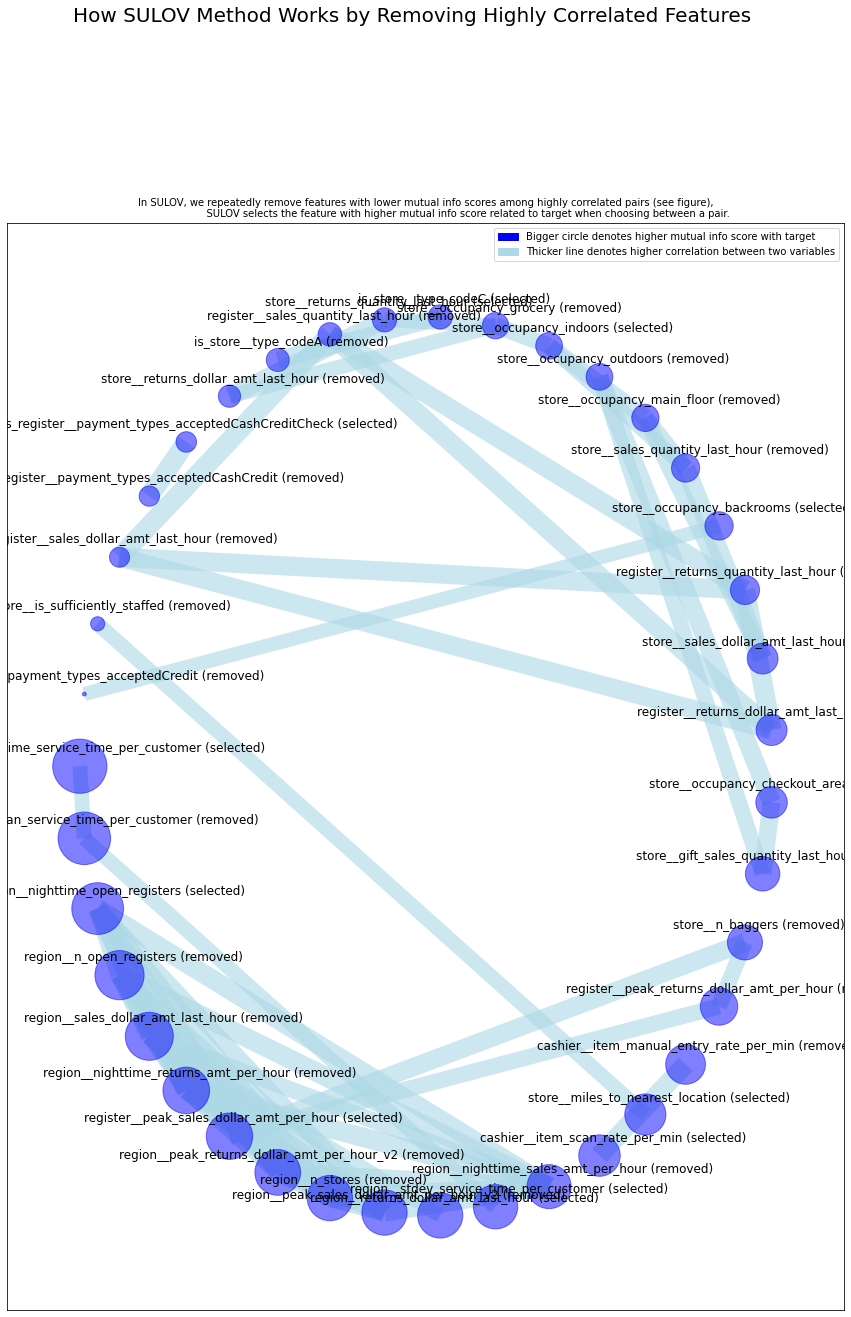

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 42
Final list of selected vars after SULOV = 42
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors = 42 
    XGBoost version using 1.5.2 as tree method: hist
Number of booster rounds = 100
        using 42 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 34 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 26 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 18 variables...
            Time

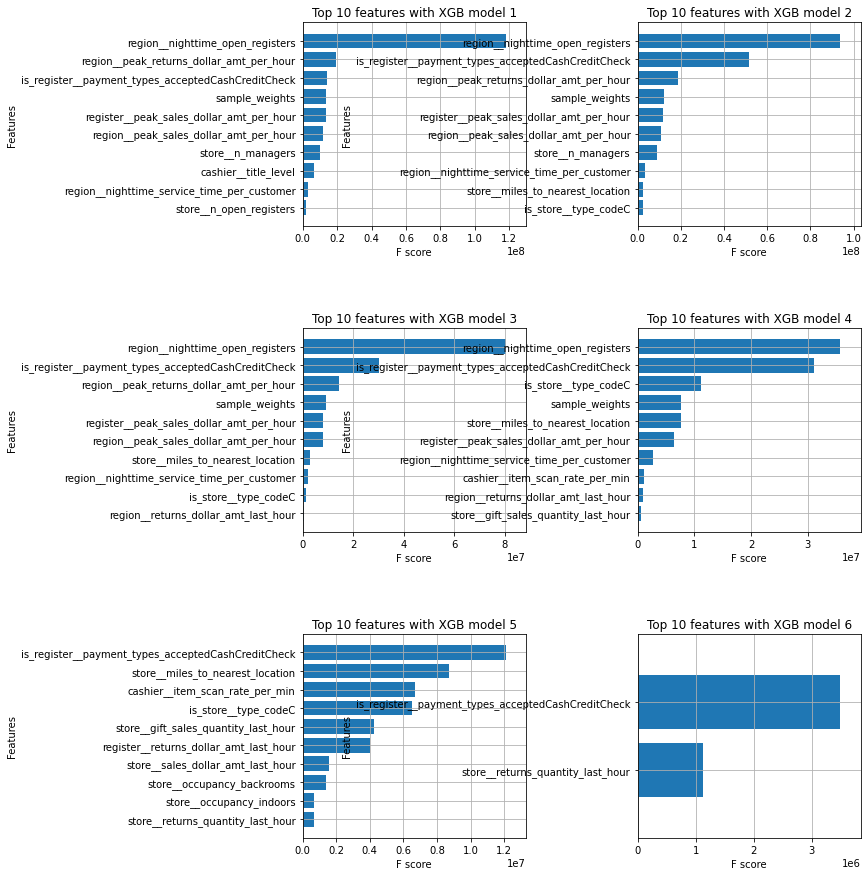

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 19 important features:
['region__nighttime_open_registers', 'region__peak_returns_dollar_amt_per_hour', 'is_register__payment_types_acceptedCashCreditCheck', 'sample_weights', 'register__peak_sales_dollar_amt_per_hour', 'region__peak_sales_dollar_amt_per_hour', 'store__n_managers', 'cashier__title_level', 'region__nighttime_service_time_per_customer', 'store__miles_to_nearest_location', 'is_store__type_codeC', 'cashier__item_scan_rate_per_min', 'region__returns_dollar_amt_last_hour', 'store__gift_sales_quantity_last_hour', 'register__returns_dollar_amt_last_hour', 'store__sales_dollar_amt_last_hour', 'store__occupancy_backrooms', 'store__occupancy_indoors', 'store__

In [20]:
# Feature selection using featurewiz
features, train = featurewiz(train_df_notimestamp, target_col, corr_limit=0.7, verbose=2,sep=',',
                            header=0, test_data="", feature_engg="", category_encoders="")

In [22]:
features

['region__nighttime_open_registers',
 'region__peak_returns_dollar_amt_per_hour',
 'is_register__payment_types_accepted=Cash+Credit+Check',
 'sample_weights',
 'register__peak_sales_dollar_amt_per_hour',
 'region__peak_sales_dollar_amt_per_hour',
 'store__n_managers',
 'cashier__title_level',
 'region__nighttime_service_time_per_customer',
 'store__miles_to_nearest_location',
 'is_store__type_code=C',
 'cashier__item_scan_rate_per_min',
 'region__returns_dollar_amt_last_hour',
 'store__gift_sales_quantity_last_hour',
 'register__returns_dollar_amt_last_hour',
 'store__sales_dollar_amt_last_hour',
 'store__occupancy_backrooms',
 'store__occupancy_indoors',
 'store__returns_quantity_last_hour']

## Build training & validation Datasests

In [82]:
################################################################################
# Build train/test datasets that are suitable as modeling inputs
################################################################################

# Extract features, targets, and (optionally) weights
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values
wt_train = train_df['sample_weights'].values

X_test = test_df[feature_cols].values
#y_test = test_df[target_col].values # Commented out as y_test does not exist in the data

X_valid = valid_df[feature_cols].values
y_valid = valid_df[target_col].values

print('Dataset Summary')
print('-'*40)
print('Train:         {0:>5d} samples  x  {1:d} features '.format(X_train.shape[0], X_train.shape[1]))
print('Test:          {0:>5d} samples  x  {1:d} features '.format(X_test.shape[0], X_test.shape[1]))
print('Validation:    {0:>5d} samples  x  {1:d} features '.format(X_valid.shape[0], X_valid.shape[1]))


Dataset Summary
----------------------------------------
Train:         14809 samples  x  64 features 
Test:           5179 samples  x  64 features 
Validation:     3703 samples  x  64 features 


## Build the XGBoost Model

In [88]:
################################################################################
# Train an XGBoost model w/ hyperparameter tuning 
################################################################################

# Set up the ranges of hyperparameters to test
optimize_hyperparameters = True
n_runs = 250    # Number of pts to test during random search optimization
hyperparameter_space = {
    'n_estimators': [10,75],
    'learning_rate': [0.05,0.5],
    'max_depth': [1,4]
}
default_hyperparameters = {'n_estimators': 64, 'learning_rate': 0.2551, 'max_depth': 5}    # Used when tuning is skipped
metric_to_optimize = 'racc'    # Options: ['rmse', 'r2', 'mae', 'mape', 'racc']

# (OPTIONAL) Optimize hyperparameters via random search, if desired
if ( optimize_hyperparameters ):
    [xgb_model, hyperparameters, _] = random_search_xgb(hyperparameter_space, 
                                                        X_train, 
                                                        y_train, 
                                                        wt_train=wt_train,
                                                        n_runs=n_runs,
                                                        metric_to_optimize=metric_to_optimize)

# Otherwise, just train a model on the default parameters
else:
    hyperparameters = default_hyperparameters
    xgb_model = train_model_xgb(hyperparameters, X_train, y_train, wt_train=wt_train)
    

XGBoost Hyperparameter Search
----------------------------------------
Method:       random-search
Dataset:      14809 pts x 64 dimensions
Optimizer:    RACC
# of Runs:    250

Hyperparameter Space:
-- n_estimators:    [10, 75]
-- learning_rate:   [0.05, 0.5]
-- max_depth:       [1, 4]


Progress: Run #250 / 250   -->   Hyperparameters: {'n_estimators': 11, 'learning_rate': 0.1231713227507265, 'max_depth': 4}                                                                                  


Search Complete
----------------------------------------
Optimal Params:      {'n_estimators': 40, 'learning_rate': 0.13478028380460927, 'max_depth': 4}
Model Performance:   racc = 0.8155
Params Evaluated:    250
Execution Time:      206.75s



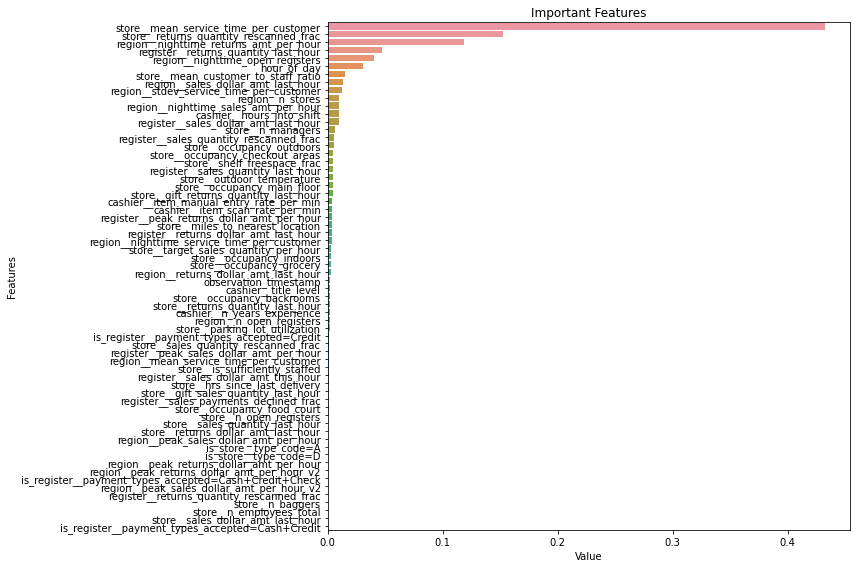

In [103]:
# Plotting feature importances in descending order
feature_imp = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, train_df.columns)), columns=['Value','Features'])

plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Important Features')
plt.tight_layout()
plt.show()

## Evaluate the performance of the model

    prediction
0  1460.392822
1   205.070160
2  1342.107910
3  1938.529297
4   348.703217
Model Performance Summary
Target: Register Sales Per Hour ($/hr)
----------------------------------------
Hyperparameters
-- n_estimators:    40
-- max_depth:       4
-- learning_rate:   0.135

Model Performance (Train)
# of Samples: 14809
-- R^2:    0.9288 +/- 0.0042
-- RMSE:   218.36 +/- 5.09
-- MAE:    126.57 +/- 1.22
-- MAPE:     19.1 +/- 1.2%
-- RAcc relative:    81.55 +/- 0.79%

Model Performance (Test)
# of Samples: 3703
-- R^2:    0.9409
-- RMSE:   198.59
-- MAE:    125.11
-- MAPE:     17.9%
-- RAcc relative :    80.15%



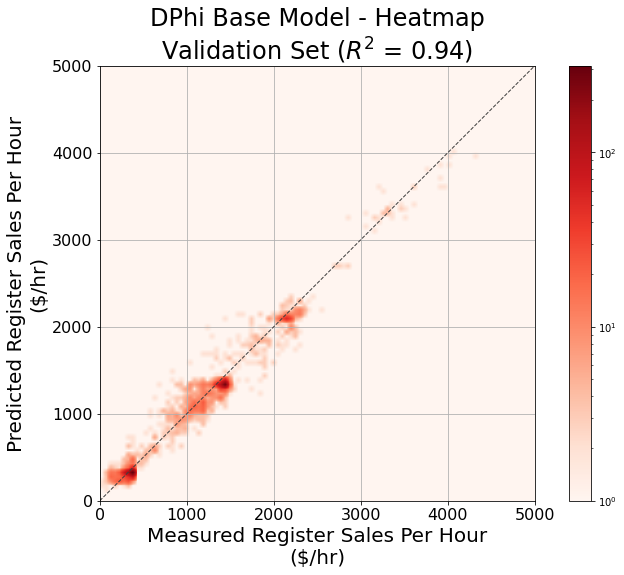

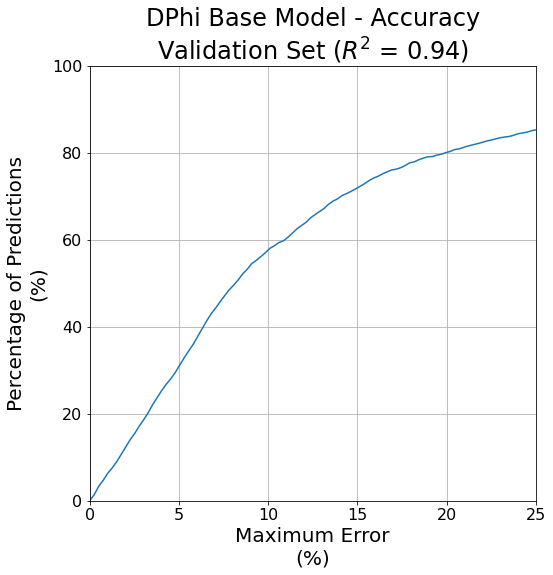

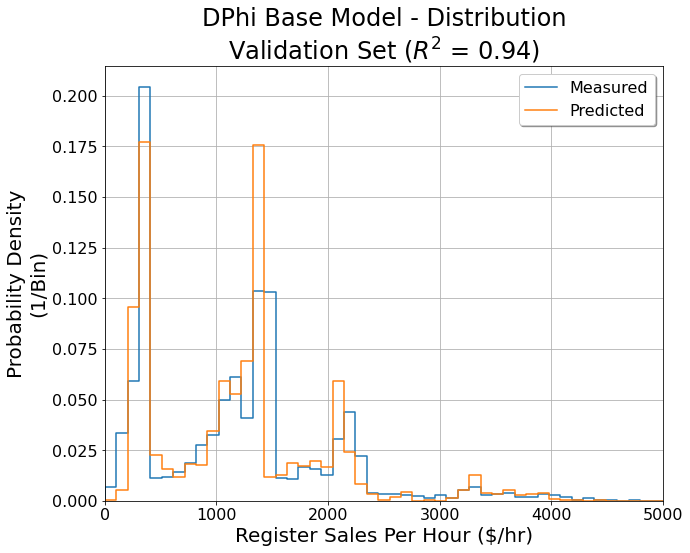

In [91]:
################################################################################
# Evaluate model performance ('validation' dataset)
# NOTE: Make sure 'valid_df' is already loaded & the data has been transformed!
################################################################################

# Evaluate model performance on both train/validation datasets
[eval_results__train, eval_results__test] = evaluate_regression_model(xgb_model, 
                                                                      X_train=X_train, y_train=y_train, wt_train=wt_train, 
                                                                      X_test=X_valid, y_test=y_valid, 
                                                                      y_lims=[0,None])
y_meas = eval_results__test['data']['y_meas']
y_pred = eval_results__test['data']['y_pred']
r2 = eval_results__test['r2']
result_df = pd.DataFrame({'prediction':y_pred})
print(result_df.head())
result_df.to_csv('validation_results.csv', index=False)
# Print a performance summary
n_samples__train = X_train.shape[0]
n_samples__test = X_valid.shape[0]
print('Model Performance Summary')
print('Target: {0:s} ({1:s})'.format(target_label, target_units))
print('-'*40)
print('Hyperparameters')
print('-- {0:<16s} {1:d}'.format('n_estimators:', hyperparameters['n_estimators']))
print('-- {0:<16s} {1:d}'.format('max_depth:', hyperparameters['max_depth']))
print('-- {0:<16s} {1:3.3f}'.format('learning_rate:', hyperparameters['learning_rate']))
print('\nModel Performance (Train)')
print('# of Samples: {0:d}'.format(n_samples__train))
print('-- R^2:  {0:>8.4f} +/- {1:3.4f}'.format(eval_results__train['r2']['mean'], eval_results__train['r2']['std']))
print('-- RMSE: {0:>8.2f} +/- {1:3.2f}'.format(eval_results__train['rmse']['mean'], eval_results__train['rmse']['std']))
print('-- MAE:  {0:>8.2f} +/- {1:3.2f}'.format(eval_results__train['mae']['mean'], eval_results__train['mae']['std']))
print('-- MAPE: {0:>8.1f} +/- {1:3.1f}%'.format(100*eval_results__train['mape']['mean'], 100*eval_results__train['mape']['std']))
print('-- RAcc relative: {0:>8.2f} +/- {1:3.2f}%'.format(100*eval_results__train['racc']['mean'], 100*eval_results__train['racc']['std']))
print('\nModel Performance (Test)')
print('# of Samples: {0:d}'.format(n_samples__test))
print('-- R^2:  {0:>8.4f}'.format(eval_results__test['r2']))
print('-- RMSE: {0:>8.2f}'.format(eval_results__test['rmse']))
print('-- MAE:  {0:>8.2f}'.format(eval_results__test['mae']))
print('-- MAPE: {0:>8.1f}%'.format(100*eval_results__test['mape']))
print('-- RAcc relative : {0:>8.2f}%'.format(100*eval_results__test['racc']))
print()

# Heatmap: Predicted vs. measured values
n_bins = 100
bins = np.linspace(target_range[0], target_range[1], n_bins)
title = 'DPhi Base Model - Heatmap\nValidation Set ($R^2$ = {0:3.2f})'.format(r2)
xlabel = 'Measured {0:s}\n({1:s})'.format(target_label, target_units)
ylabel = 'Predicted {0:s}\n({1:s})'.format(target_label, target_units)
output_filepath = '{0:s}/predicted_vs_measured__heatmap__validation_dataset.png'.format(output_path)
plot_heatmap(y_meas, y_pred,
             title=title, xlabel=xlabel, ylabel=ylabel,
             x_bins=bins, y_bins=bins, plot_diagonal=True, 
             output_filepath=output_filepath)

# Accuracy: Predicted vs. measured values
title = 'DPhi Base Model - Accuracy\nValidation Set ($R^2$ = {0:3.2f})'.format(r2)
xlabel = 'Maximum Error\n({0:s})'.format('%')
ylabel = 'Percentage of Predictions\n(%)'
output_filepath = '{0:s}/predicted_vs_measured__accuracy__validation_dataset.png'.format(output_path)
plot_regression_accuracy(y_meas, y_pred, max_error=25, error_type='relative', 
                         title=title, ylabel=ylabel, output_filepath=output_filepath)

# Distributions of Predicted & Measured Values
n_bins = 50
bins = np.linspace(target_range[0], target_range[1], n_bins)
data_labels = ['Measured', 'Predicted']
title = 'DPhi Base Model - Distribution\nValidation Set ($R^2$ = {0:3.2f})'.format(r2)
xlabel = '{0:s} ({1:s})'.format(target_label, target_units)
output_filepath = '{0:s}/predicted_vs_measured__distribution__validation_dataset.png'.format(output_path)
plot_distribution([y_meas, y_pred], data_labels=data_labels, bins=bins, 
                  title=title, xlabel=xlabel, hist_units='probability', 
                  output_filepath=output_filepath)


# Observations of Model Training -> Normal Features without experimental - (Normal + Experimental Features)

When the model was trained with 64 features excluding the experimental features and other columns like observation_id, non-encoded categorical original columns, the score on the public leaderboard was observed as 82%.
## Scores of model trained using normal features only without using experimental features:
#### Model Performance (Train)
#### of Samples: 14809
-- R^2:    0.9390 +/- 0.0029
-- RMSE:   202.09 +/- 4.41
-- MAE:    111.02 +/- 0.66
-- MAPE:     15.8 +/- 0.9%
-- RAcc relative:    82.97 +/- 0.45%

#### Model Performance (Test)
### of Samples: 3703
-- R^2:    0.9507
-- RMSE:   181.34
-- MAE:    109.91
-- MAPE:     14.9%
-- RAcc relative :    81.99%

But after including the experimental features, the score on public leaderboard increased by 0.32% i.e., 82.32%.
## Scores of model trained using normal features as well as experimental features:
#### Model Performance (Train)
#### of Samples: 14809
-- R^2:    0.9384 +/- 0.0028
-- RMSE:   203.10 +/- 4.69
-- MAE:    111.23 +/- 0.98
-- MAPE:     15.6 +/- 0.8%
-- RAcc relative:    82.73 +/- 0.43%

#### Model Performance (Test)
#### of Samples: 3703
-- R^2:    0.9476
-- RMSE:   187.01
-- MAE:    111.69
-- MAPE:     15.2%
-- RAcc relative :    81.61%

There were slight changes in the regression accuracy.

## Make Predictions

In [92]:
X_test.shape

(5179, 64)

In [93]:
predictions = xgb_model.predict(X_test)

In [94]:
print(predictions)

[1766.5356   321.17252 1346.2502  ...  828.34155 1215.6184  1124.2397 ]


# CATBOOST

## Export predictions into a .csv file for submission

In [95]:
results_df = pd.DataFrame({'prediction':predictions})

In [96]:
results_df.head()

,prediction
0,1766.535645
1,321.172516
2,1346.250244
3,338.943817
4,313.331818


In [97]:
results_df.to_csv('predictions.csv',index=False)